# HW 1, High-dimensional data

In [1]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

PATH_DATA = os.path.join('data', 'mnist-hw1.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Считываем датасет

In [2]:
with open(PATH_DATA, 'rb') as file:
    dataset = pickle.load(file)
    
xs_train = dataset['train']
xs_val = dataset['test']

Создаем даталоадеры для удобства

In [3]:
batch_size = 128

def collate_fn(xs):
    xs = torch.LongTensor(xs)
    xs = xs.permute(0, 3, 1, 2)
    return xs

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

## 3.1 PixelCNN

Нам будет нужна двухмерная свертка с маской

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        
        self.register_buffer('mask', torch.ones_like(self.weight))
        _, _, h, w = self.mask.size()
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

Также сделаем блок PixelCNN

In [5]:
class MaskResBlock(nn.Module):
    def __init__(self, h=128):
        super(MaskResBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, 3, 1, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        x = self.layers(x) + x
        return x

И сам PixelCNN

In [6]:
class PixelCNN(nn.Module):
    def __init__(self, h=128):
        super(PixelCNN, self).__init__()

        layers = [MaskedConv2d('A', 3, 2 * h, 7, 1, 3)]
        layers += [MaskResBlock(h) for _ in range(12)]
        layers += [
            nn.ReLU(),
            nn.Conv2d(2 * h, 2 * h, 1),
            nn.BatchNorm2d(2 * h),
            nn.ReLU(),
            nn.Conv2d(2 * h, 3 * 4, 1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        n, c, h, w = x.shape
        x = self.layers(x)
        x = x.reshape(n, c, 4, h, w)
        x = x.permute(0, 1, 3, 4, 2)
        return x

В качестве ошибки все еще будет логарифмическая функцию правдоподобия

In [7]:
class MLLELoss(nn.Module):
    eps = 1e-9
    
    def __init__(self):
        super(MLLELoss, self).__init__()

    def forward(self, ps, xs):
        ps = F.softmax(ps, dim=-1)
        xs = F.one_hot(xs, -1).float()
        ps = (ps * xs).sum(dim=-1)
        loss = -torch.log(ps + MLLELoss.eps)
        loss = loss.mean()
        return loss

Функция для обучения

In [8]:
def train(model, criterion, optimizer, epochs):
    losses_train = []
    losses_val = []
    for i in tqdm(range(epochs)):
        losses = []
        model.train()
        for xs in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            ps = model(xs)
            loss = criterion(ps, xs)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                xs = xs.to(device)
                
                ps = model(xs)
                loss = criterion(ps, xs)

                losses.append(loss.item())

        losses_val.append(np.array(losses).mean())

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

Функция для сэмплирования изображений из модели

In [9]:
def sample_images(model, n=100):
    samples = np.zeros((n, 28, 28, 3), dtype=np.uint8)
    with torch.no_grad():
        for y in tqdm(range(28)):
            for x in range(28):
                for c in range(3):
                    xs = collate_fn(samples)
                    ps = model(xs)
                    ps = F.softmax(ps, dim=4).numpy()
                    for i in range(n):
                        samples[i, y, x, c] = np.random.choice(
                            4, p=ps[i, c, y, x])
                        
    samples *= 85
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(samples):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

Функция для нахождения receptive field'а одного выходного пикселя

In [10]:
def receptive_field(model):
    xs = xs_val[:100]
    xs = collate_fn(xs)
    xs_f = torch.tensor(
        xs.numpy().astype(np.float32),
        requires_grad=True
    )
    
    ps = model(xs_f)[:, 0, 14, 14]
    
    criterion = MLLELoss()
    
    loss = criterion(ps, xs[:, 0, 14, 14])
    loss.backward()
    
    img = xs_f.grad.abs().sum(dim=(0, 1))
    img /= img.max()
    img = img > 0
    img = img.float().numpy()
    
    plt.imshow(img)
    plt.show()

Обучим PixelCNN. Увы, с $8$ фичами вместо $128$, так как не было GPU. Поэтому все результаты соответствующие.

100%|██████████| 50/50 [4:29:18<00:00, 329.53s/it]  


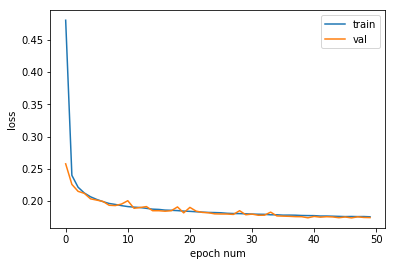

In [11]:
epochs = 50
lr = 0.001
w_l2 = 0

model = PixelCNN(h=8) # h=128
model.to(device)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion, optimizer, epochs)

Сэмплируем картинки

100%|██████████| 28/28 [01:43<00:00,  3.39s/it]


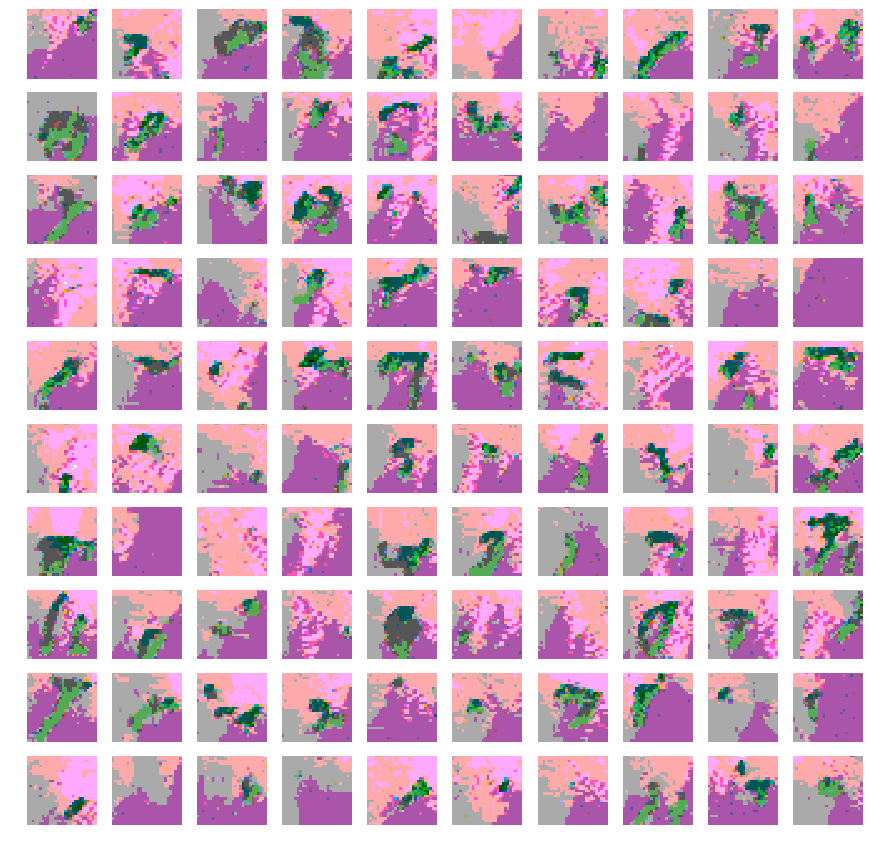

In [12]:
model.eval()
sample_images(model)

И строим receptive field

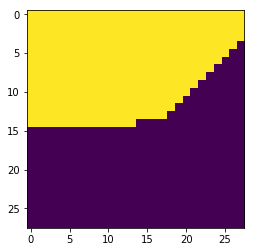

In [13]:
model = PixelCNN()
model.to(device)
model.eval()
receptive_field(model)

## 3.2 PixelCNN-MADE

Здесь так же будет нужна маскированная свертка. НО. Здесь нужно будет так же маскировать центральнную матрицу ядра сверки, которая переводит пиксиль сам в себя. Он будет маскироваться, как в MADE. 

Единственное, получается, что в такой схеме правило маскирования центральной матрицы ядра свертки будет одним и тем же для вообще всех пикселей. 

In [11]:
class MaskedMADEConv2d(nn.Conv2d):
    def __init__(self, mask_type, c_in, c_out, k,
                 d=None, m_in=None, m_out=None,
                 *args, **kwargs):
        super(MaskedMADEConv2d, self).__init__(
            c_in, c_out, k, *args, **kwargs)
        
        self.register_buffer('mask', torch.ones_like(self.weight))
        _, _, h, w = self.mask.size()
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0
        
        if mask_type == 'B':
            self.m_in = m_in.copy()
            if m_out is None:
                self.m_out = np.random.randint(
                    self.m_in.min(), d, size=c_out)
            else:
                self.m_out = m_out.copy()
                
            center_mask = self.m_out.reshape(-1, 1) >= self.m_in.reshape(1, -1)
            center_mask = center_mask.astype(np.float32)
            center_mask = torch.tensor(center_mask)
            self.mask[:, :, h // 2, w // 2] = center_mask
        else:
            self.m_out = np.zeros(c_out)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedMADEConv2d, self).forward(x)

Блок для PixelCNN-MADE

In [12]:
class MaskMADEResBlock(nn.Module):
    def __init__(self, m_in, h=128):
        super(MaskMADEResBlock, self).__init__()
        
        self.m_in = m_in
        layers = [
            nn.ReLU(),
            MaskedMADEConv2d(
                'B', 2 * h, h, 1,
                d=3, m_in=self.m_in
            ),
            nn.BatchNorm2d(h)
        ]
        layers += [
            nn.ReLU(),
            MaskedMADEConv2d(
                'B', h, h, 3, stride=1, padding=1,
                d=3, m_in=layers[-2].m_out
            ),
            nn.BatchNorm2d(h)
        ]
        layers += [
            nn.ReLU(),
            MaskedMADEConv2d(
                'B', h, 2 * h, 1,
                d=3, m_in=layers[-2].m_out
            ),
            nn.BatchNorm2d(2 * h)
        ]
        self.m_out = layers[-2].m_out
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x) + x
        return x

Сам PixelCNN-MADE

In [13]:
class PixelCNNMADE(nn.Module):
    def __init__(self, h=128):
        super(PixelCNNMADE, self).__init__()

        layers = [
            MaskedMADEConv2d('A', 3, 2 * h, 7, stride=1, padding=3)
        ]
        for _ in range(12):
            layers.append(MaskMADEResBlock(layers[-1].m_out, h))
        layers += [
            nn.ReLU(),
            MaskedMADEConv2d(
                'B', 2 * h, 2 * h, 1,
                d=3, m_in=layers[-1].m_out
            ),
            nn.BatchNorm2d(2 * h)
        ]
        layers += [
            nn.ReLU(),
            MaskedMADEConv2d(
                'B', 2 * h, 3 * 4, 1, 
                d=3,
                m_in=layers[-2].m_out,
                m_out=np.repeat(np.arange(3), 4) + 1
            )
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        n, c, h, w = x.shape
        x = self.layers(x)
        x = x.reshape(n, c, 4, h, w)
        x = x.permute(0, 1, 3, 4, 2)
        return x

Обучаем... (ну его я вообще уже не успел нормально обучить)

100%|██████████| 2/2 [10:30<00:00, 314.94s/it]


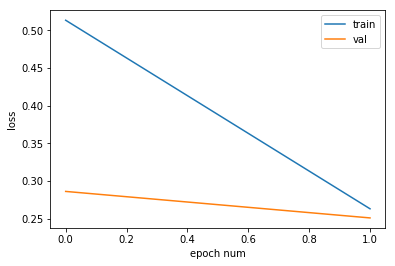

In [14]:
epochs = 2 # 50
lr = 0.001
w_l2 = 0

model = PixelCNNMADE(h=8) # h=128
model.to(device)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion, optimizer, epochs)

Сэмплируем картинки

100%|██████████| 28/28 [04:32<00:00,  9.80s/it]


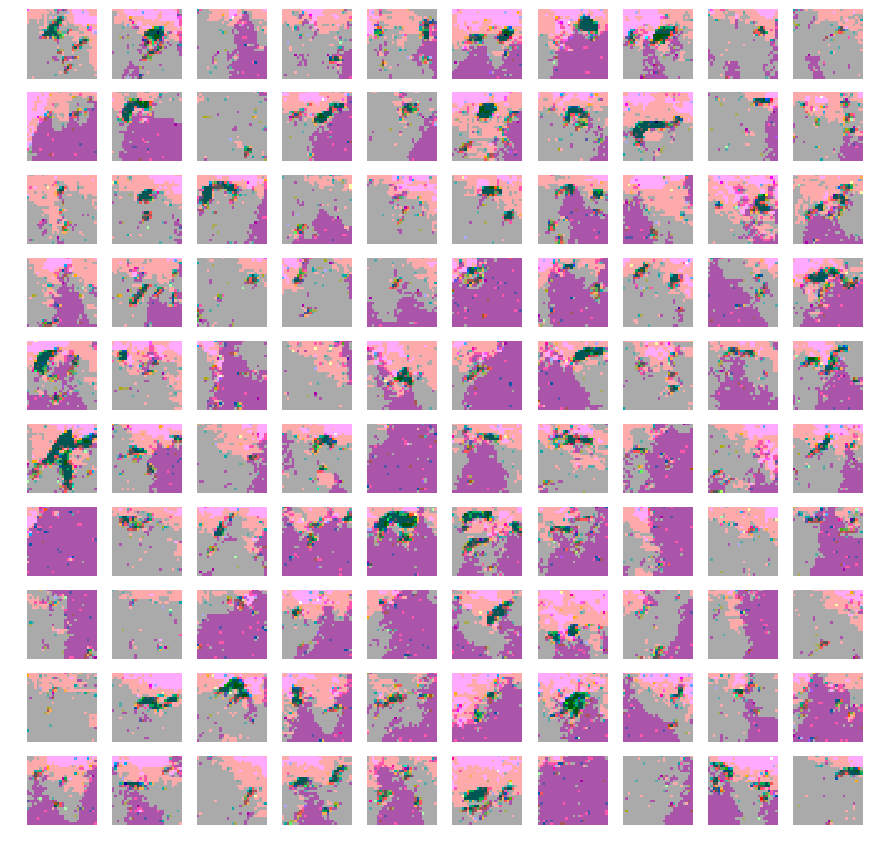

In [15]:
model.eval()
sample_images(model)

И строим receptive field

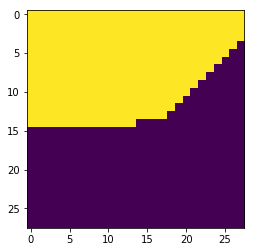

In [16]:
model = PixelCNNMADE()
model.to(device)
model.eval()
receptive_field(model)